In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size':22})

import warnings
warnings.filterwarnings('ignore')

[10.22520118] [0.26805485]
[9.82570729] [0.36711051]
[11.7864229] [0.40233803]
[11.02834106] [0.29488345]
=========K0=========
[2.5 2.5 2.4 2.1 2.4]
=========Kc=========
[3.4 3.3 3.9 3.4 0. ]


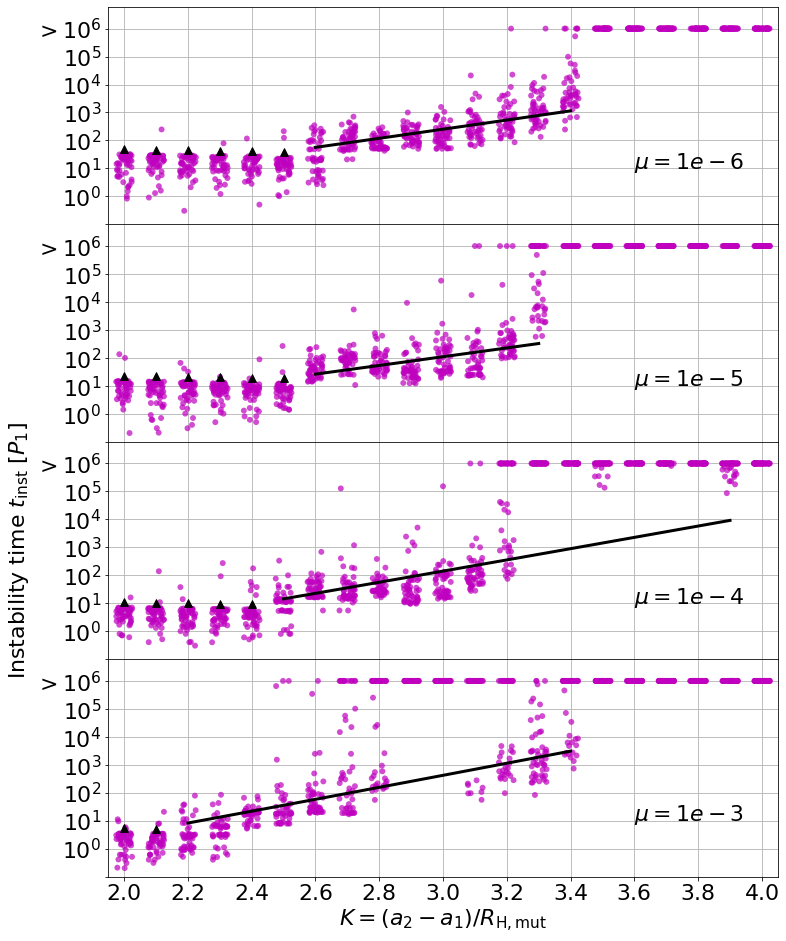

In [8]:
def Tins_fit_full(K,b,mu,K0,Kc):
    return  np.log(K_to_Tsyn(K,mu) * np.exp(b*(K-K0)/K0))


def K_to_Tsyn(K,mu):
    a1 = 1.
    eta = (mu/3.)**(1./3.)
    RH = (eta/(1.-0.5*K*eta)) * a1
    a2 = a1+ K*RH
    T1 = a1**1.5
    T2 = a2**1.5
    Tsyn = 1/(1./T1-1./T2)
    return Tsyn

def resonance_to_K(res_val,m1,m2):
    P1 = 1.**(-1.5)
    P2 = P1*res_val
    a1 = P1**(2./3.)
    a2 = P2**(2./3.)
    RH = 0.5*(a1+a2) * ((m1+m2)/3.)**(1./3.)
    return (a2-a1)/RH

from scipy.optimize import curve_fit

def frac_fit(K,Kcr,Kwid):
    return 1./(1.+np.exp(-(K-Kcr)/Kwid))

def frac_fit2(K,Kcr):
    return 1./(1.+np.exp(-(K-Kcr)/0.1))

plt.rcParams.update({'font.size':22})

fig,axs = plt.subplots(4,1, sharex=True, figsize=(12,16))
fig.subplots_adjust(hspace=0.0)
fig.subplots_adjust(wspace=0.0)


plt.rcParams.update({'font.size':22})

K_crit = 3.33697392249

cuse = plt.rcParams['axes.prop_cycle'].by_key()['color']
cuse = ['m','m','m','m','m']


dir_name_list = ['6','5','4','3']
mu_l = [1e-6,1e-5,1e-4,1e-3]
K0_l = [2.6,2.6,2.5,2.5,2.4]
Kc_l = [.0,.0,.0,.0,.0]


for iii in range(len(dir_name_list)):
    
    def Tins_fit(K,b):
        return  Tins_fit_full(K,b,mu_l[iii],K0_l[iii],Kc_l[iii])

    curr_dir = dir_name_list[iii]

    kk_list = np.linspace(2.0,4.0,21)
    
    coll_t = np.zeros((len(kk_list)))
    ejec_t = np.zeros((len(kk_list)))
    ejec_m = np.zeros((len(kk_list)))
    safe_t = np.zeros((len(kk_list)))
    mist_t = np.zeros((len(kk_list)))
    alpha_array = kk_list*0

    X_fit = np.array([])
    Y_fit = np.array([])
    
    mu = mu_l[iii]
    Tsyn_list = K_to_Tsyn(kk_list,mu)
    
    for i in range(len(kk_list)):
        kk = kk_list[i]
        dir_str = str(int(kk*10))
        dir_name_str = './20220126/N2/m'+curr_dir+'t0T6/all_Tinst/Tinst-K'+dir_str
        #dir_name_str = 'd:/_work/K-test/LR-eps-2/wKt/mu-'+curr_dir+'-nf-wKt/collect_data/K'+dir_str
        all_data = np.load(dir_name_str+'.npy')

        Nrun = len(all_data[:,0])

        RH_data = all_data[ all_data[:,1]>0.5 , : ]
        sf_data = all_data[ all_data[:,0]>0.5 , : ]

        if RH_data.ndim >= 2:
            RH_time = RH_data[:,3]
            axs[iii].scatter(RH_time*0+kk_list[i]+(np.random.rand(len(RH_time))-0.5)*0.05,
                               RH_time,color=cuse[iii],s=35,alpha=0.7,edgecolors='none')

            
            N1T = np.sum(RH_time<Tsyn_list[i])
            Nin = np.sum(RH_time>0)
            
            if N1T > Nrun*0.75:
                K0_l[iii] = kk_list[i]
            
            if Nin > Nrun*0.001:
                Kc_l[iii] = max(kk_list[i],Kc_l[iii])
            
        if sf_data.ndim >= 2:
            sf_time = sf_data[:,3]
            axs[iii].scatter(sf_time*0+kk_list[i]+(np.random.rand(len(sf_time))-0.5)*0.05,
                               sf_time,color=cuse[iii],s=35,alpha=0.7,edgecolors='none')


    for i in range(len(kk_list)):
        kk = kk_list[i]
        dir_str = str(int(kk*10))
        dir_name_str = './20220126/N2/m'+curr_dir+'t0T6/all_Tinst/Tinst-K'+dir_str
        #dir_name_str = 'd:/_work/K-test/LR-eps-2/wKt/mu-'+curr_dir+'-nf-wKt/collect_data/K'+dir_str
        all_data = np.load(dir_name_str+'.npy')

        RH_data = all_data[ all_data[:,1]>0.5 , : ]

        if RH_data.ndim >= 2:
            RH_time = RH_data[:,3]
            
            N1T = np.sum(RH_time<Tsyn_list[i])
            Nin = np.sum(RH_time>0)
            
            if (kk>K0_l[iii]) and (kk<Kc_l[iii]):
                    
                X_fit = np.append(X_fit,RH_time*0+kk_list[i])
                Y_fit = np.append(Y_fit,RH_time)   
                
    popt, pcov = curve_fit(Tins_fit, X_fit, np.log(Y_fit))
    kk_fit = np.linspace(K0_l[iii]+0.1,Kc_l[iii],11)
    axs[iii].plot(kk_fit, np.exp(Tins_fit(kk_fit, *popt)), color='k', linewidth=3)#,label='fit: b=%5.3f' % tuple(popt))
    axs[iii].text(3.6,10,r'$\mu=1e-%d$'%int(curr_dir))
    #axs[iii].legend(loc=4)
            
    axs[iii].grid()
    axs[iii].set_axisbelow(True)
    axs[iii].set_yscale('log')
    axs[iii].set_ylim([3.0e0,6e6])
    axs[iii].set_yticks([1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
  
    #popt, pcov = curve_fit(Tins_fit, X_fit, np.log(Y_fit))
    #kk_fit = np.linspace(K0_l[iii]+0.1,Kc_l[iii],11)
    #axs[iii].plot(kk_fit, np.exp(Tins_fit(kk_fit, *popt)), color='k', linewidth=3)#,label='fit: b=%5.3f' % tuple(popt))
    #axs[iii].text(4.3,10,r'$\mu=1e-%d$'%int(curr_dir))
    #axs[iii].legend(loc=4)
    
    print(popt,np.sqrt(np.diag(pcov)))

    
for i in range(4):
    mu = mu_l[i]
    Tsyn_list = K_to_Tsyn(kk_list,mu)
    axs[i].scatter(kk_list[kk_list<=K0_l[i]],Tsyn_list[kk_list<=K0_l[i]],color='k',marker='^',s=60)


print('=========K0=========')
print(np.round(K0_l,decimals=1))
print('=========Kc=========')
print(np.round(Kc_l,decimals=1))

    
axs[3].set_xlabel(r'$K= (a_2-a_1)/R_{\rm H,mut}}$')
axs[2].set_ylabel(r'Instability time $t_{\rm inst}$ [$P_1$]')


axs[iii].set_xlim([1.95,4.05])
axs[3].set_xticks(np.linspace(2.0,4.0,11))

axs[0].set_yticklabels(['',r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$',r'$>10^6$'])
axs[1].set_yticklabels(['',r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$',r'$>10^6$'])
axs[2].set_yticklabels(['',r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$',r'$>10^6$'])
axs[3].set_yticklabels(['',r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$',r'$>10^6$'])

#axs[3].axvline(x=resonance_to_K(7./6.,1e-4,0))
#axs[4].axvline(x=resonance_to_K(7./5.,1e-3,0))


#axs.set_title(r'no friction, final $e/\epsilon>0.5$')
plt.rcParams.update({'font.size':22})

plt.savefig('./pics/pics-time_nf-N2-T6.pdf',bbox_inches='tight',transparent=True)
plt.savefig('./pics/pics-time_nf-N2-T6.png',bbox_inches='tight',transparent=True)

plt.rcParams.update({'font.size':22})